In [18]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*

#Open ROOT file with uproot--------------------------------------------------------------------------------------------
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 

#Get trees-------------------------------------------------------------------------------------------------------------
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

dr_mins=[0.1, 0.1, 0.1, 0.2]
dr_maxs=[0.3, 0.4, 0.6, 0.4]



nmin1=0
nmax1=5000

Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Initialize lists
ZeroBias_isolations_dr=[]
ZeroBias_ratios_dr=[]
Zmumu_isolations_dr=[]
Zmumu_ratios_dr=[]

for dr_min, dr_max in zip(dr_mins, dr_maxs):
    Zmumu_iso=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, [nmin1, nmax1])
    Zmumu_ratio=ak.flatten(Zmumu_iso)/ak.flatten(Zmumu_pt)

    Zmumu_iso=ak.flatten(Zmumu_iso)
    Zmumu_iso=Zmumu_iso[~np.isnan(Zmumu_iso)]
    l1=len(ak.flatten(Zmumu_pt))
    l3=len(Zmumu_iso)


    datasets=1000
    e_cut= 14000
    ZeroBias_pt_total=[]
    ZeroBias_eta_total=[]
    ZeroBias_phi_total=[]
    iso_total=[]
    ratio_total=[]
    num_events=0
    # Define  directory
    base_path = "/home/ruben/Escritorio/BachelorThesisRuben/Data/NewData/"
    # List directories 0, 1, 2, ...
    folders = [str(f) for f in range(datasets)]
    # Loop through the folders
    i=0
    for folder in tqdm(folders, desc="Loading data...", leave=False):
        file_path = os.path.join(base_path, folder, 'l1calo_hist.root')
        # Check if the file exists before attempting to open it
        if os.path.exists(file_path):
            # Open the ROOT file
            file = uproot.open(file_path)
            #Since datasets 998 and 999 are different, this "if" ensures they are loaded correctly
            if i == 999:
                Tree="MuonTree_ZeroBias;1"
                MuonTree_ZeroBias=file[Tree]
            else:
                Tree="MuonTree;1"
                MuonTree_ZeroBias=file[Tree]
            
            ###############################################################################################################################3
            #Select ZeroBias
            num_events=num_events+len(MuonTree_ZeroBias["muon_pt"].array())
            ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array(), e_cut)
            ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array(), e_cut)
            ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array(), e_cut)

            Zbl1_pt = MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
            Zbl1_eta = MuonTree_ZeroBias["LVL1Muon_eta"].array()
            Zbl1_phi = MuonTree_ZeroBias["LVL1Muon_phi"].array()

            #Compute matchings
            mask = offline_LVL1_matcher(ZeroBias_eta, ZeroBias_phi, Zbl1_eta, Zbl1_phi)
            #Apply them
            ZeroBias_pt=ZeroBias_pt[mask]
            ZeroBias_eta=ZeroBias_eta[mask]
            ZeroBias_phi=ZeroBias_phi[mask]
            #Compute isolations 
            iso=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [0, len(ZeroBias_pt)])
            ratio=ak.flatten(iso)/ak.flatten(ZeroBias_pt)
            #Concatenate with other data
            ZeroBias_pt_total=ak.concatenate([ZeroBias_pt_total,ZeroBias_pt[ak.num(ZeroBias_pt) > 0]])
            ZeroBias_eta_total=ak.concatenate([ZeroBias_eta_total,ZeroBias_eta[ak.num(ZeroBias_pt) > 0]])
            ZeroBias_phi_total=ak.concatenate([ZeroBias_phi_total,ZeroBias_phi[ak.num(ZeroBias_pt) > 0]])

            iso_total=ak.concatenate([iso_total, iso])
            ratio_total=ak.concatenate([ratio_total, ratio])

        i=i+1
    #Remove nan and empty
    iso_total=iso_total[~np.isnan(iso_total)]
    ZeroBias_iso=iso_total[ak.num(iso_total) > 0]
    ZeroBias_ratio=ratio_total[~np.isnan(ratio_total)]
    print("Number of events scanned", num_events)
    print("Post-selected ZeroBias length", len(ZeroBias_pt_total))
    print("Total Isolation length", len(ZeroBias_iso))

    ZeroBias_isolations_dr.append(ZeroBias_iso)
    ZeroBias_ratios_dr.append(ZeroBias_ratio)
    Zmumu_isolations_dr.append(Zmumu_iso)
    Zmumu_ratios_dr.append(Zmumu_ratio)

100%|██████████| 5000/5000 [00:08<00:00, 614.10it/s]


KeyboardInterrupt: 

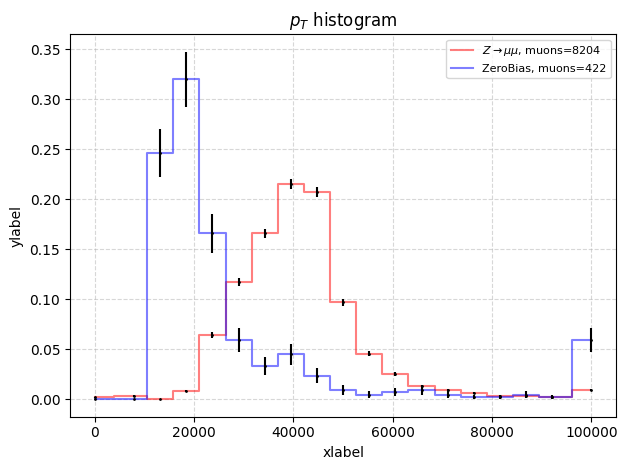

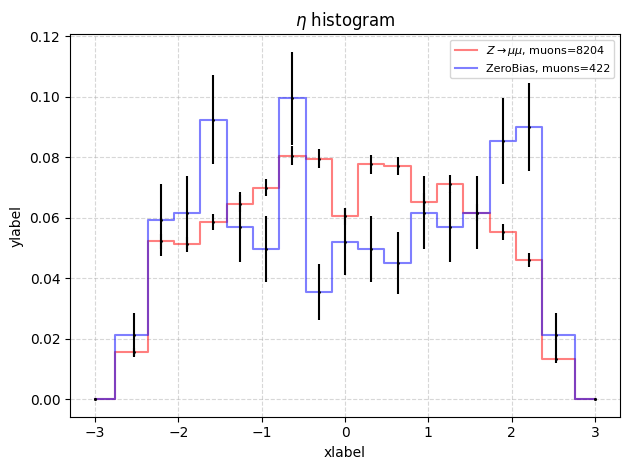

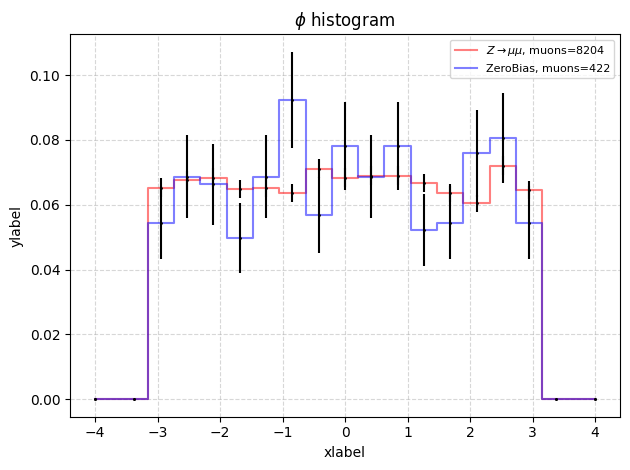

In [6]:
l2=len(ak.flatten(ZeroBias_pt_total[ak.num(ZeroBias_pt_total) > 0]))
coolplot([Zmumu_pt, ZeroBias_pt_total], np.linspace(0,10*10**4,20), labels=[rf"$Z\to\mu\mu$, muons={l1}", f"ZeroBias, muons={l2}"], title=r"$p_T$ histogram")
coolplot([Zmumu_eta, ZeroBias_eta_total], np.linspace(-3,3,20), labels=[rf"$Z\to\mu\mu$, muons={l1}", f"ZeroBias, muons={l2}"], title=r"$\eta$ histogram")
coolplot([Zmumu_phi, ZeroBias_phi_total], np.linspace(-4,4,20), labels=[rf"$Z\to\mu\mu$, muons={l1}", f"ZeroBias, muons={l2}"], title=r"$\phi$ histogram")

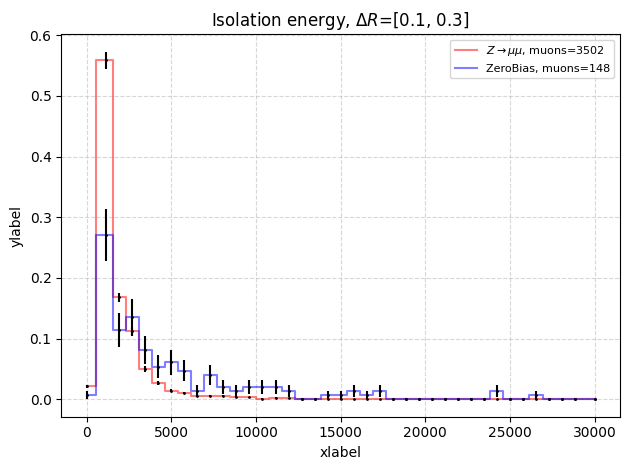

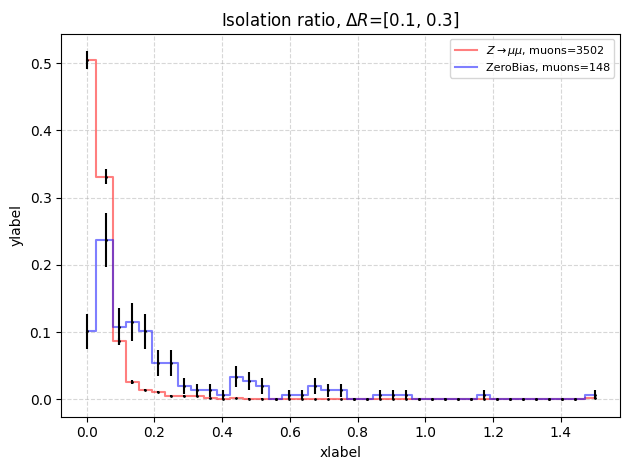

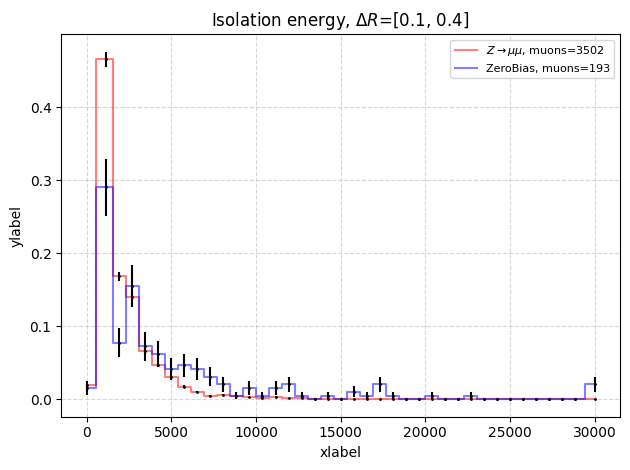

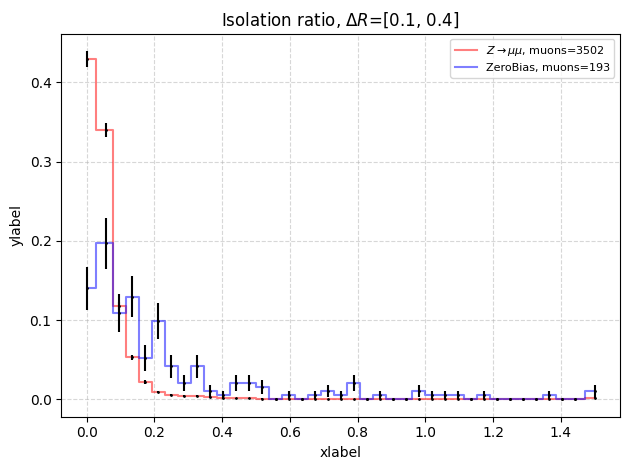

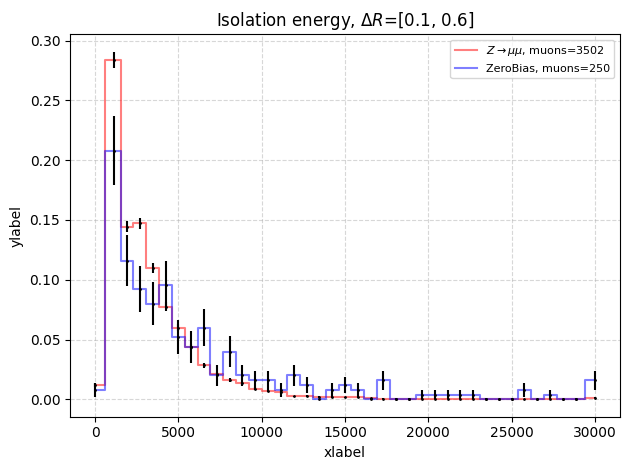

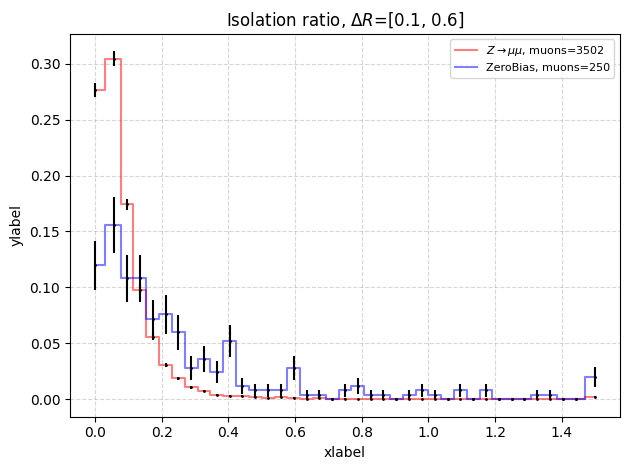

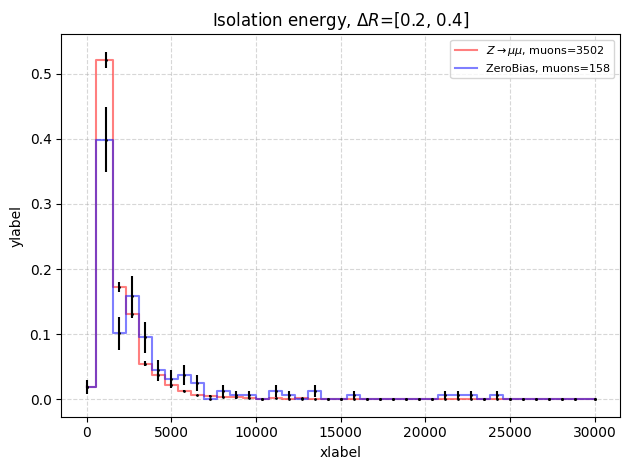

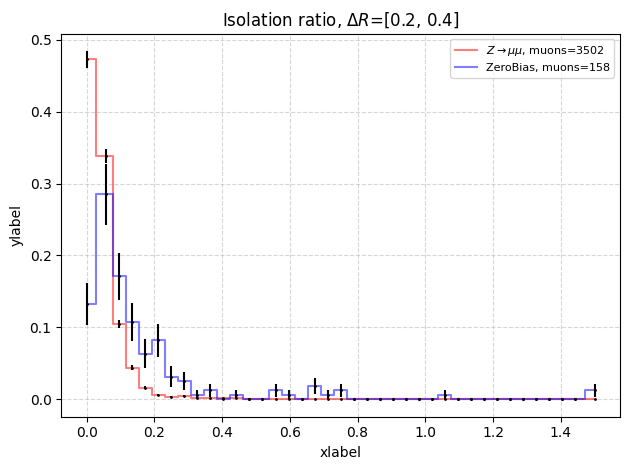

In [7]:
i=0
for ZeroBias_iso, ZeroBias_ratio, Zmumu_iso, Zmumu_ratio in zip(ZeroBias_isolations_dr, ZeroBias_ratios_dr,
                                                                 Zmumu_isolations_dr, Zmumu_ratios_dr):
    l4=len(ZeroBias_iso)
    coolplot([Zmumu_iso, ZeroBias_iso], bins=np.linspace(0,30000,40), 
            labels=[rf"$Z\to\mu\mu$, muons={l3}", f"ZeroBias, muons={l4}"], title=rf"Isolation energy, $\Delta R$=[{dr_mins[i]}, {dr_maxs[i]}]")
    coolplot([Zmumu_ratio, ZeroBias_ratio], bins=np.linspace(0,1.5,40),
            labels=[rf"$Z\to\mu\mu$, muons={l3}", f"ZeroBias, muons={l4}"], title=rf"Isolation ratio, $\Delta R$=[{dr_mins[i]}, {dr_maxs[i]}]")
    i=i+1

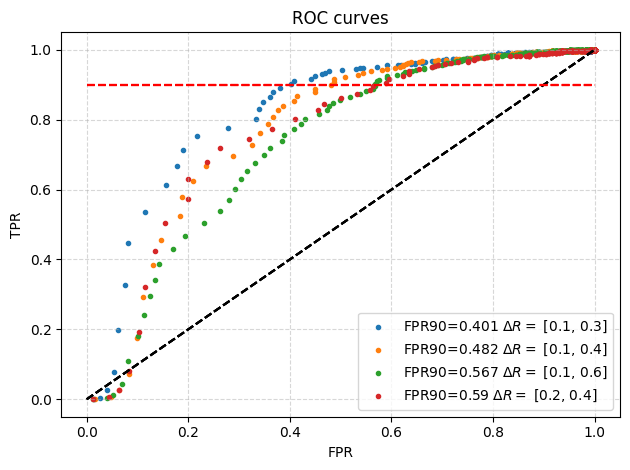

In [8]:
i=0
for ZeroBias_iso, ZeroBias_ratio, Zmumu_iso, Zmumu_ratio in zip(ZeroBias_isolations_dr, ZeroBias_ratios_dr,
                                                                 Zmumu_isolations_dr, Zmumu_ratios_dr):
    bins=np.linspace(0,1.5,300)
    Zmumu_counts, _ = np.histogram(Zmumu_ratio, bins)
    ZeroBias_counts, _ = np.histogram(ZeroBias_ratio, bins)
    #Compute the cumulative sum of the counts (like integrating the histogram to the left)
    Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
    ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
    # Normalize to total events
    TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
    FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)

    FPR90=min(FPR[TPR >= 0.9])
    plt.scatter(FPR, TPR, marker='.', label=fr'FPR90={np.round(FPR90,3)} $\Delta R=$ [{dr_mins[i]}, {dr_maxs[i]}]')
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.plot([0,1],[0.9,0.9],color='r', linestyle='--')
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title(rf"ROC curves")
    plt.tight_layout()

    i=i+1

In [3]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*

file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

dr_mins=[0.1, 0.1, 0.1, 0.2]
dr_maxs=[0.3, 0.4, 0.6, 0.4]

nmin1=0
nmax1=5000

Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

100%|██████████| 5000/5000 [00:05<00:00, 885.36it/s]


In [4]:
#Open ROOT file with uproot--------------------------------------------------------------------------------------------
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/zbV3_skim.root") 

MuonTree_ZeroBias=file["MuonTree;1"]

ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())
ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())
ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())

Zbl1_pt=MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
Zbl1_eta=MuonTree_ZeroBias["LVL1Muon_eta"].array()
Zbl1_phi=MuonTree_ZeroBias["LVL1Muon_phi"].array()

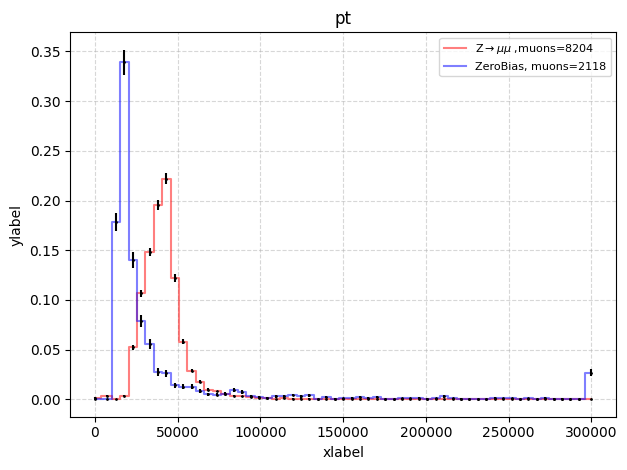

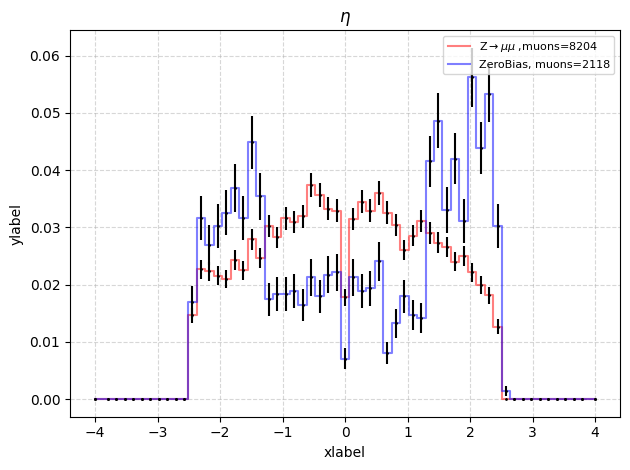

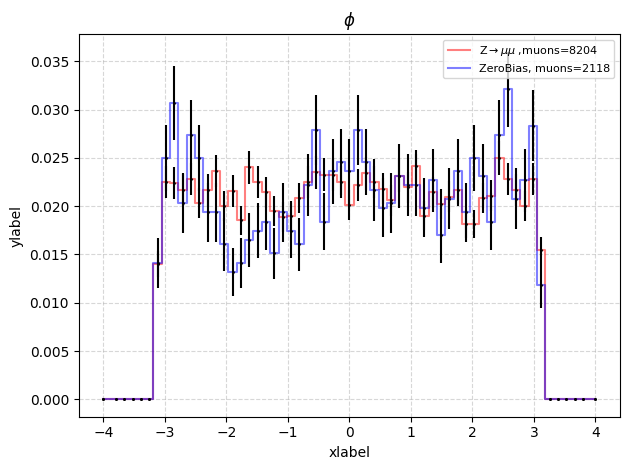

In [ ]:
l1=len(ak.flatten(Zmumu_pt))
l2=len(ak.flatten(ZeroBias_pt))
coolplot([Zmumu_pt, ZeroBias_pt], np.linspace(0,20*10**4, 60), labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title="pt")
coolplot([Zmumu_eta, ZeroBias_eta], np.linspace(-3,3, 60), labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title=r"$\eta$")
coolplot([Zmumu_phi, ZeroBias_phi], np.linspace(-4,4, 60), labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title=r"$\phi$")

In [ ]:
#Get isolation energy
ZeroBias_iso=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, 0.1, 0.4, [0, len(ZeroBias_eta)])
Zmumu_iso=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, 0.1, 0.4, [0, len(Zmumu_eta)])

#Get ratio
ZeroBias_ratio=ak.flatten(ZeroBias_iso)/ak.flatten(ZeroBias_pt)
Zmumu_ratio=ak.flatten(Zmumu_iso)/ak.flatten(Zmumu_pt)

#Remove NaN
ZeroBias_iso=ak.flatten(ZeroBias_iso)
Zmumu_iso=ak.flatten(Zmumu_iso)
ZeroBias_iso=ZeroBias_iso[~np.isnan(ZeroBias_iso)]
Zmumu_iso=Zmumu_iso[~np.isnan(Zmumu_iso)]

ZeroBias_ratio=ZeroBias_ratio[~np.isnan(ZeroBias_ratio)]
Zmumu_ratio=Zmumu_ratio[~np.isnan(Zmumu_ratio)]

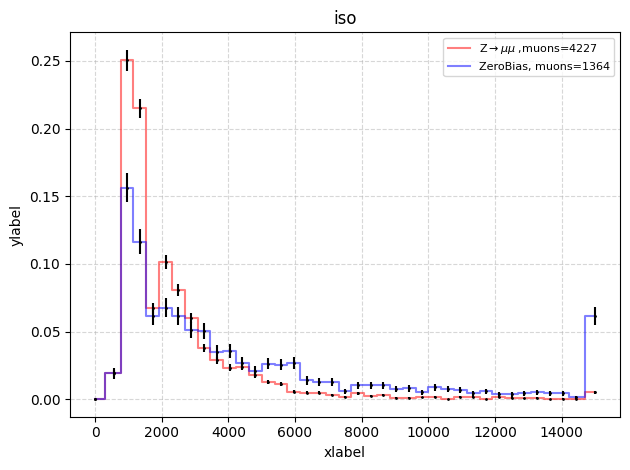

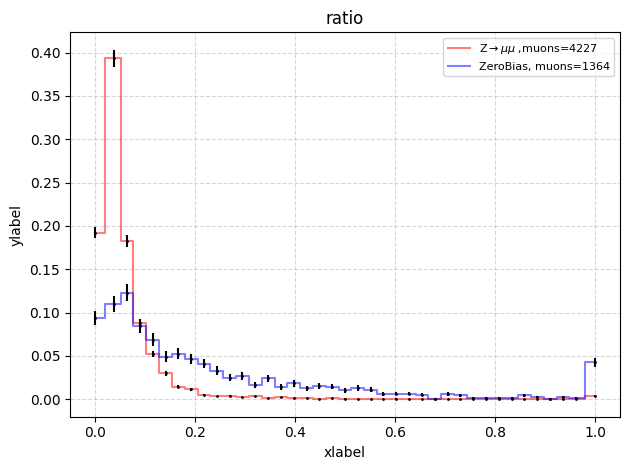

In [102]:
l1=len(Zmumu_iso)
l2=len(ZeroBias_iso)
coolplot([Zmumu_iso, ZeroBias_iso], np.linspace(0,15*10**3, 40), labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title="iso")
coolplot([Zmumu_ratio, ZeroBias_ratio], np.linspace(0,1, 40), labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title="ratio")

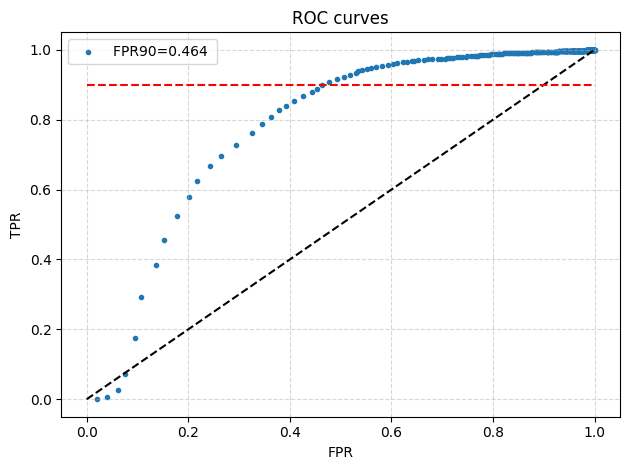

In [106]:
bins=np.linspace(0,1.5,300)
Zmumu_counts, _ = np.histogram(Zmumu_ratio, bins)
ZeroBias_counts, _ = np.histogram(ZeroBias_ratio, bins)
#Compute the cumulative sum of the counts (like integrating the histogram to the left)
Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
# Normalize to total events
TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)

FPR90=min(FPR[TPR >= 0.9])
plt.scatter(FPR, TPR, marker='.', label=fr'FPR90={np.round(FPR90,3)} ')
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.plot([0,1],[0.9,0.9],color='r', linestyle='--')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title(rf"ROC curves")
plt.tight_layout()

In [99]:
def offline_LVL1_matcher(offline_eta, offline_phi, LVL1_eta, LVL1_phi, dr_threshold: float = 0.4):
    dr_threshold=dr_threshold**2
    if len(offline_eta) == len(LVL1_eta) == len(offline_phi) == len(LVL1_phi):
        arr1=offline_eta
        arr2=LVL1_eta

        # Assuming arr1 and arr2 are Awkward Arrays
        l_off = ak.num(arr1)  # Length of each element in arr1
        l_l1 = ak.num(arr2)   # Length of each element in arr2

        # Create a mask where the lengths are the same
        l_mask = l_off == l_l1

        # Use the mask to set elements in arr1 and arr2 to empty arrays where lengths don't match
        arr1 = ak.where(l_mask, arr1, ak.Array([[]]*len(arr1)))
        arr2 = ak.where(l_mask, arr2, ak.Array([[]]*len(arr2)))

        #Compute delta eta
        etadif=arr1-arr2

        arr1=offline_phi
        arr2=LVL1_phi

        # Assuming arr1 and arr2 are Awkward Arrays
        l_off = ak.num(arr1)  # Length of each element in arr1
        l_l1 = ak.num(arr2)   # Length of each element in arr2

        # Create a mask where the lengths are the same
        l_mask = l_off == l_l1

        # Use the mask to set elements in arr1 and arr2 to empty arrays where lengths don't match
        arr1 = ak.where(l_mask, arr1, ak.Array([[]]*len(arr1)))
        arr2 = ak.where(l_mask, arr2, ak.Array([[]]*len(arr2)))

        #Compute delta phi
        phidif=arr1-arr2
        phidif= phidif + np.pi % (2 * np.pi) - np.pi
        #Compute delta r squared
        dr=etadif**2+phidif**2

        mask= dr <= dr_threshold**2
    else:
        raise ValueError("Offline and LVL1 data inputs must have the same length") 

    return mask

In [ ]:
Zb_eta= ZeroBias_eta[ak.num(ZeroBias_eta) > 0]
Zbl1_eta = Zbl1_eta[ak.num(Zbl1_eta) > 0]
i=0
for event1 in tqdm(arr1):
    for muon1 in event1:
        for event2 in arr2:
            for muon2 in event2:
                res=muon1-muon2

        

  1%|          | 14/2115 [01:43<4:19:56,  7.42s/it]


KeyboardInterrupt: 

In [ ]:
Zb_eta= ZeroBias_eta[ak.num(ZeroBias_eta) > 0]
Zblvl1_eta = Zbl1_eta[ak.num(Zbl1_eta) > 0]
Zb_phi= ZeroBias_phi[ak.num(ZeroBias_eta) > 0]
Zblvl1_phi = Zbl1_phi[ak.num(Zbl1_eta) > 0]

In [ ]:
def offline_LVL1_matcher(offline_eta, offline_phi, LVL1_eta, LVL1_phi, dr_threshold: float = 0.4):
    mask_total=[]
    dr_theshold=dr_threshold**2

    for event_eta, event_phi, lvl1_event_eta, lvl1_event_phi in tqdm(zip(offline_eta, offline_phi, LVL1_eta, LVL1_phi)):
        mask_event=[]
        for muon_eta, muon_phi in zip(event_eta, event_phi):
            d_eta=muon_eta-lvl1_event_eta
            d_phi=muon_phi-lvl1_event_phi
            d_phi=d_phi + np.pi % (2 * np.pi) - np.pi
            dr=d_eta**2+d_phi**2
            mask_event.append(np.any(dr <= dr_theshold, axis=-1))
        mask_total.append(mask_event)

    return mask_total

In [ ]:
mask = offline_LVL1_matcher(Zb_eta, Zb_phi, Zblvl1_eta, Zblvl1_phi)
mask

Fix 

Heatmap

Plot mu